# 초기 학습 모델 
- 텍스트 전처리<br/>
(1) 정규표현식을 활용한 전처리 (2) Tokenizing 문법적 의미가 있는 최소 단위인 토큰으로 분리 (3) Stemming, 어간 추출 (4) 불용어 제거 (5) 형태소 분석


- 단어 빈도수를 기반으로, 문서를 벡터로 표현하는 방법<br/>
(1) Bag of Words 모델 (2) N-gram 모델 **(3) TF-IDF**


- **머신러닝 기반의 학습 모델**<br/>
(1) 로지스틱 회귀 모델 (2) 트리 모델 
  

- 딥러닝 기반의 학습 모델<br/>
뉴럴 네트워크 모델 - RNN, LSTM, GRU 등등



## 1. 데이터셋 로드

In [30]:
import numpy as np
import pandas as pd

dataset = pd.read_csv('./Dataset_Hojun_Seojin.csv', index_col = 'id')

# 현재 0~7000, 7000 ~ 8000, 14001~ 까지 라벨링됨
valid_class = ['0', '1', '2', '3', '4', '5']
df_labeled = pd.merge(dataset.iloc[0:8001], dataset.iloc[14001:], how='outer')
df_positive = df_labeled[(df_labeled["label"] == 1) & (df_labeled["label2"] == '-1')]
df_negative = df_labeled[(df_labeled["label"] == 0) & (df_labeled["label2"].isin(valid_class))]

In [156]:
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [31]:
df_labeled

,document,label,label2
0,몇년간 잘만 쓰고 있었는데요,0,0
1,최근 업뎃이후로 너무 불편해서 리뷰를 다 써보러 와요,0,0
2,업뎃후 적응이야 늘 하는거지만 적당히 바껴야되는데,0,3
3,대체 좋아요 랑 댓글 위치까진ㅋㅋㅋㅋㅋ왜 바꾸는건짘ㅋㅋㅋㅠㅠ너무 자주 바뀌는 설정들...,0,0
4,군대 전역전까지 메롱쓰다가 년 전역후부터 지니뮤직으로 갈아탄후 계속 사용하고있는 유...,0,3
...,...,...,...
16092,그리고 한시간전에 리뷰남겼는데 맘대로 삭제가 됐네요,0,2
16093,아니 왜 포인트에 관한게 하나도 안뜨냐 인터넷이랑 공지사항보고 하란대로 다했는데 포...,0,2
16094,기가지니에서는 끊기네요,0,1
16095,이제는 노래 재생도 안된다,0,4


In [32]:
df_positive

,document,label,label2
20,그래도 좋은 앱 만들어주셔서 감사합니다,1,-1
24,너무 좋네요,1,-1
25,이번 업데이트 아주 맘에 들어요 ㅠ,1,-1
26,그동안 플레이리스트 편집하려면 너무 귀찮았고 새 곡 추가해도 앨범 다시 열어줘야 했...,1,-1
27,진짜 최고 편해요 ㅠㅠ,1,-1
...,...,...,...
16027,지니 뮤직으로 음악 잘 듣고 있습니다,1,-1
16041,음악을 검색하면 바로 음악을 들을 수 있어서 좋아요,1,-1
16042,업데이트 한 후 기타 미디어 재생 시 노래가 끊기지 않음,1,-1
16083,노래 잘듣고있습니다,1,-1


In [33]:
df_negative

,document,label,label2
0,몇년간 잘만 쓰고 있었는데요,0,0
1,최근 업뎃이후로 너무 불편해서 리뷰를 다 써보러 와요,0,0
2,업뎃후 적응이야 늘 하는거지만 적당히 바껴야되는데,0,3
3,대체 좋아요 랑 댓글 위치까진ㅋㅋㅋㅋㅋ왜 바꾸는건짘ㅋㅋㅋㅠㅠ너무 자주 바뀌는 설정들...,0,0
4,군대 전역전까지 메롱쓰다가 년 전역후부터 지니뮤직으로 갈아탄후 계속 사용하고있는 유...,0,3
...,...,...,...
16092,그리고 한시간전에 리뷰남겼는데 맘대로 삭제가 됐네요,0,2
16093,아니 왜 포인트에 관한게 하나도 안뜨냐 인터넷이랑 공지사항보고 하란대로 다했는데 포...,0,2
16094,기가지니에서는 끊기네요,0,1
16095,이제는 노래 재생도 안된다,0,4


## 2. 텍스트 전처리

### 전처리 규칙 
- 문자가 아닌 것들 제거
- 한국어 특유의 반복되는 문자 제거

In [75]:
from konlpy.tag import Okt
import re

okt = Okt()
stopwords_path = "./stopwords-ko.txt"

def openStopwords(path:str)->list:
    with open(path, 'r', encoding='utf-8') as f:
        stopwords = f.readlines()
    return [x.strip() for x in stopwords]
    
def preprocessor(text:str) -> str:
    text = re.sub('[\W]+', ' ', text)
    text = re.sub('[ㅋ|ㅠ|ㅜ|ㅎ|ㅇ|ㅡ|ㅅ|ㅂ|!|?|.|,|;]+', ' ', text)
    return text

# Stemming
def tokenizer_porter_kor(text):
    """
        norm : If True, normalize tokens
        stem : If True, stem tokens
    """
    return okt.morphs(text, norm=True, stem=True)

stopwords_ko = openStopwords(stopwords_path)
stopwords_ko.append("지니")

In [65]:
print(f"before : {df_negative.loc[3, 'document']}")
print(f"after : {preprocessor(df_negative.loc[3, 'document'])}")

before : 대체 좋아요 랑 댓글 위치까진ㅋㅋㅋㅋㅋ왜 바꾸는건짘ㅋㅋㅋㅠㅠ너무 자주 바뀌는 설정들이 번거로운게 늘 해맵니다 
after : 대체 좋아요 랑 댓글 위치까진 왜 바꾸는건짘 너무 자주 바뀌는 설정들이 번거로운게 늘 해맵니다 


### 단어 빈도수 기반의 벡터화 TF-IDF vectors

In [82]:
# vectorize texts - TF-IDF Matrix
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(strip_accents=None,
                       lowercase=False,
                       preprocessor=preprocessor,           # 각 텍스트에 대한 전처리 함수
                       tokenizer=tokenizer_porter_kor,      # 어간 추출
                       stop_words=stopwords_ko,             # removing stopwords
                       max_df=0.1,                          # 한 단어가 여러 문서에 등장하는 비율; 해당 비율 이상이면 무시
                       min_df=10)                            # 한 단어가 적어도 min_df개의 문서에는 등장하라

docs_vector = tfidf.fit_transform(df_negative['document'])


/opt/homebrew/Caskroom/miniforge/base/envs/junho_ML/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['가다', '각하', '간', '갖다', '개', '거나', '거리', '걸', '겁', '것과', '견지', '결과', '결론', '고려', '곤', '곳', '공동', '관', '관계', '관련', '구체', '구토', '그러하다', '그런', '그렇게', '그렇다', '그치다', '근거', '기대', '기점', '기준', '김', '까닭', '나머지', '남', '낫다', '낼', '년도', '논', '누가', '는', '다', '다르다', '다시', '달다', '답', '대로', '대하', '대해', '더', '더불다', '더욱이', '도', '도달', '도착', '동시', '돼다', '되다', '되어다', '두번째', '뒤', '뒤따르다', '든', '든지', '들다', '듯', '따다', '따르다', '따름', '때문', '라', '라도', '라면', '리하', '마자', '막론', '만', '만으로', '만은', '만이', '만하', '많다', '말', '말다', '망정', '메', '면', '모르다', '몰랏다', '못', '무릎', '미치다', '바', '바꾸다', '밖에', '반대', '방면', '번째', '보다', '보아', '본대', '부류', '불구', '불문', '비', '비걱거리', '비교', '비기다', '비추다', '뿐', '사람', '상대', '생각', '서', '서술', '수', '시오', '시작', '시초', '쓰다', '쓰이다', '아니다', '아래', '아무', '아우르다', '안', '안다', '안되다

In [84]:
# print(docs_vector)

## 3. 머신러닝 기반 분류 모델 

### 훈련-검증 데이터셋 

In [ ]:
import numpy as np
import pandas as pd

dataset = pd.read_csv('./Dataset_Hojun_Seojin.csv', index_col = 'id')

# 현재 0~7000, 7000 ~ 8000, 14001~ 까지 라벨링됨
valid_class = ['0', '1', '2', '3', '4', '5']
df_labeled = pd.merge(dataset.iloc[0:8001], dataset.iloc[14001:], how='outer')
df_positive = df_labeled[(df_labeled["label"] == 1) & (df_labeled["label2"] == '-1')]
df_negative = df_labeled[(df_labeled["label"] == 0) & (df_labeled["label2"].isin(valid_class))]

- test_size=0.3 : 훈련 데이터셋 70%, 검증 데이터셋 30%으로 분리
- random_state=1 : 시드값 1로 고정
- stratify=y : 전체 데이터셋에서 클래스 별 비율을 맞춰 분할

In [86]:
from sklearn.model_selection import train_test_split

X = df_negative["document"]
y = df_negative["label2"]
# 훈련 데이터셋 70% - 테스트 데이터셋 30% 분할, stratify = y
X_train, X_test,  y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [100]:
X_train

7029             밤에 차량에서 운전중 노래곡이 넘어갈때마다 화면이 켜져서 운전이 불편합니다
8295                                                     좀
11480              결제한 상태인데도 자꾸 끊기고 결제하라고 떠서 노래를 들을 수가 없어요
13110                                     트로트 차트 하나 만들어주세요
5386                                   이 오류 좀 없애주세요 ㅠㅠㅠㅋㅋㅋ
                               ...                        
1313                                                개선해주세요
8609                                 최근에 계속 지멋대로 실행푸시가 뜹니다
13277          로그인 오류랑 네트워크 오류에 서버는 자주 터지고 노래를 듣는데 지장이 많네요
13767    데이터 쓰고 와이파이 빵빵한데 네트워크가 원활하지 않다고 뜨고 노래 재생도 안되네요...
2085             음원 마음대로 들을수도 있고ㅋ 근데 이게 간헐적으로 버퍼링이 경우가 있네요
Name: document, Length: 10215, dtype: object

In [101]:
y_train

7029     3
8295     0
11480    2
13110    0
5386     2
        ..
1313     3
8609     2
13277    2
13767    2
2085     2
Name: label2, Length: 10215, dtype: object

In [98]:
X_test

531                                                너무 불편해요
15584                        아니 로그인을 꼭해야 분권한이 아니라는게 너무 싫어요
11516                         이건 뭔경우죠 돈내고 이런식으로 노래 들어야 하나요
3776           가끔 검색하면 없는 음악들이 있는데 그점만 보완되면 더 좋을거같네요 번창하세용
7729                           다른 어플들은 정상 작동되는데 지니만 안되서요ㅠㅠ
                               ...                        
7325                                      범죄자들 노래를 듣고싶지않아요
6458                    마이 앨범에 넣은 곡 순서는 어떻게 바꾸고 삭제는 어떻게 해요
11904                                            지금이 일째입니다
15812    없는노래 너무만타 일부로 여기까지와서 글남긴다 돈아까울만큼 찾는노래마다 플레이안됨 ...
13795                                             딱 필요한 기능
Name: document, Length: 4378, dtype: object

3

#### 데이터 분포 검증

In [167]:
series = pd.Series([int(y_train[idx]) for idx in y_train.index])
series

0        3
1        0
2        2
3        0
4        2
        ..
10210    3
10211    2
10212    2
10213    2
10214    2
Length: 10215, dtype: int64

In [172]:
arr = [0, 0, 0, 0, 0, 0]
for idx in series.index:
    arr[series[idx]]+=1
arr

[3845, 1007, 2346, 1931, 356, 730]

In [175]:
def plotAsPieChart(series):
    series = pd.Series([int(series[idx]) for idx in series.index])
    arr = [0, 0, 0, 0, 0, 0]
    for idx in series.index:
        arr[series[idx]]+=1
    arrSeries = pd.Series(arr)
    # xlabel = ["단순부정", "앱 개발팀", "서비스 개발팀", "서비스 기획팀", "콘텐츠 운영팀", "IT 기획팀"]
    wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
    
    plt.title("클래스 별 부정 라벨링 데이터")
    arrSeries.plot.pie(autopct="%.2f%%", startangle=90, wedgeprops=wedgeprops)
#    plt.pie(ratio, labels = xlabel, autopct="%.1f%%", startangle=90, wedgeprops=wedgeprops)
    plt.figure(figsize=(10,10))
    plt.rcParams["figure.figsize"] = (8,10)
    plt.show()

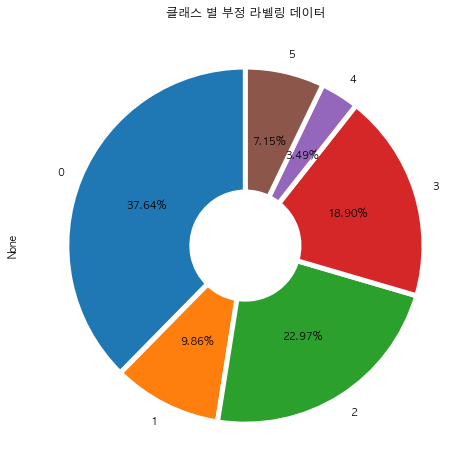

<Figure size 720x720 with 0 Axes>

In [176]:
plotAsPieChart(y_train)

### 각 데이터셋에 대해 자연어처리

In [180]:
### from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(strip_accents=None,
                       lowercase=False,
                       preprocessor=preprocessor,           # 각 텍스트에 대한 전처리 함수
                       tokenizer=tokenizer_porter_kor,      # 어간 추출
                       stop_words=stopwords_ko,             # removing stopwords
                       max_df=0.1,                          # 한 단어가 여러 문서에 등장하는 비율; 해당 비율 이상이면 무시
                       min_df=10)                            # 한 단어가 적어도 min_df개의 문서에는 등장하라

X_train_vector = tfidf.fit_transform(X_train)
X_test_vector = tfidf.transform(X_test)

In [181]:
# data dimension
X_train_vector = X_train_vector.toarray()
X_test_vector = X_test_vector.toarray()
X_train_vector.shape

(10215, 1166)

In [185]:
print(X_train[1])
print(X_train_vector[1])

최근 업뎃이후로 너무 불편해서 리뷰를 다 써보러 와요 
[0. 0. 0. ... 0. 0. 0.]


### Logistic Regression

In [186]:
# train using Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty="l2", verbose=1)
lr.fit(X_train_vector, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         7002     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.83028D+04    |proj g|=  2.14250D+03

At iterate   50    f=  9.82713D+03    |proj g|=  1.46728D+01

At iterate  100    f=  9.81302D+03    |proj g|=  9.08994D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 7002    100    112      1     0     0   9.090D-01   9.813D+03
  F =   9813.0208494395429     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/homebrew/Caskroom/miniforge/base/envs/junho_ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s finished


LogisticRegression(verbose=1)

In [187]:
# train score
lr.score(X_train_vector, y_train)

0.6860499265785609

In [188]:
# test score
lr.score(X_test_vector, y_test)

0.6265417999086341

In [189]:
# sentiment prediction example 
reviews = ["네트워크에 문제가 많네요", 
          "노래 재생이 멈췄어요", 
          "아이폰 사용하는데 문제가 많아요"]

reviews_tfidf = tfidf.transform(reviews)
lr.predict(reviews_tfidf)

array(['5', '1', '0'], dtype=object)

### Decision Tree

In [190]:
# train using Decision Tree
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=20)
tree.fit(X_train_vector, y_train)

DecisionTreeClassifier(max_depth=20)

In [191]:
# train score
tree.score(X_train_vector, y_train)

0.6834067547723935

In [192]:
# test score
tree.score(X_test_vector, y_test)

0.5395157606212883

In [193]:
# finding most important terms
importances = tree.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(10):
    print("%2d. %-30s %f" % (f+1, 
                             [w for w, n in tfidf.vocabulary_.items() if n == indices[f]],
                             importances[indices[f]]))

 1. ['네트워크']                       0.152822
 2. ['로그인']                        0.063473
 3. ['기능']                         0.054398
 4. ['좋다']                         0.039723
 5. ['곡']                          0.035152
 6. ['끊기다']                        0.026973
 7. ['계속']                         0.021479
 8. ['목록']                         0.021461
 9. ['연결']                         0.018191
10. ['업데이트']                       0.018136


### 정확도 개선하기
- ngram 범위를 늘려주면?

In [194]:
### from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(strip_accents=None,
                       lowercase=False,
                       preprocessor=preprocessor,           # 각 텍스트에 대한 전처리 함수
                       tokenizer=tokenizer_porter_kor,      # 어간 추출
                       stop_words=stopwords_ko,             # removing stopwords
                       ngram_range=(1,4),
                       max_df=0.1,                          # 한 단어가 여러 문서에 등장하는 비율; 해당 비율 이상이면 무시
                       min_df=10)                            # 한 단어가 적어도 min_df개의 문서에는 등장하라

X_train_vector = tfidf.fit_transform(X_train)
X_test_vector = tfidf.transform(X_test)

/opt/homebrew/Caskroom/miniforge/base/envs/junho_ML/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['가다', '각하', '간', '갖다', '개', '거나', '거리', '걸', '겁', '것과', '견지', '결과', '결론', '고려', '곤', '곳', '공동', '관', '관계', '관련', '구체', '구토', '그러하다', '그런', '그렇게', '그렇다', '그치다', '근거', '기대', '기점', '기준', '김', '까닭', '나머지', '남', '낫다', '낼', '년도', '논', '누가', '는', '다', '다르다', '다시', '달다', '답', '대로', '대하', '대해', '더', '더불다', '더욱이', '도', '도달', '도착', '동시', '돼다', '되다', '되어다', '두번째', '뒤', '뒤따르다', '든', '든지', '들다', '듯', '따다', '따르다', '따름', '때문', '라', '라도', '라면', '리하', '마자', '막론', '만', '만으로', '만은', '만이', '만하', '많다', '말', '말다', '망정', '메', '면', '모르다', '몰랏다', '못', '무릎', '미치다', '바', '바꾸다', '밖에', '반대', '방면', '번째', '보다', '보아', '본대', '부류', '불구', '불문', '비', '비걱거리', '비교', '비기다', '비추다', '뿐', '사람', '상대', '생각', '서', '서술', '수', '시오', '시작', '시초', '쓰다', '쓰이다', '아니다', '아래', '아무', '아우르다', '안', '안다', '안되다

### Logistic Regression

In [213]:
# train using Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty="l2", verbose=1, random_state=1)
lr.fit(X_train_vector, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        16434     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.83028D+04    |proj g|=  2.14250D+03

At iterate   50    f=  9.69176D+03    |proj g|=  3.51740D+01

At iterate  100    f=  9.67626D+03    |proj g|=  1.12137D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
16434    100    108      1     0     0   1.121D+00   9.676D+03
  F =   9676.2573977097927     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/homebrew/Caskroom/miniforge/base/envs/junho_ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


LogisticRegression(random_state=1, verbose=1)

In [214]:
# train score
lr.score(X_train_vector, y_train)

0.716789035731767

In [215]:
# test score
lr.score(X_test_vector, y_test)

0.6231155778894473

In [232]:
# sentiment prediction example 
reviews = ["네트워크에 문제가 많네요", 
          "노래 재생이 멈췄어요", 
          "아이폰 사용하는데 문제가 많아요",
          "아이폰에서 작동이 안되요",
          "이걸 왜 만듬?",
          "내가 만들어도 잘 만들듯ㅋ",
          "유투브 뮤직 쓸거에요",
          "이용권 결제했는데 제대로 반영이 안되었어요",
          "다크모드가 안보여서 불편해요",
          "UI가 구려요",
          "노래 좀 추가해주세요",
          "노래가 별로 없어요"]

reviews_tfidf = tfidf.transform(reviews)
lr.predict(reviews_tfidf)

array(['5', '1', '0', '1', '0', '3', '0', '0', '3', '0', '4', '0'],
      dtype=object)

### Decision Tree

In [212]:
# train using Decision Tree
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=20)
tree.fit(X_train_vector, y_train)

DecisionTreeClassifier(max_depth=20)

In [201]:
# train score
tree.score(X_train_vector, y_train)

0.6850709740577582

In [202]:
# test score
tree.score(X_test_vector, y_test)

0.5509365006852444

In [203]:
# finding most important terms
importances = tree.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(10):
    print("%2d. %-30s %f" % (f+1, 
                             [w for w, n in tfidf.vocabulary_.items() if n == indices[f]],
                             importances[indices[f]]))

 1. ['네트워크']                       0.151391
 2. ['로그인']                        0.065791
 3. ['기능']                         0.054982
 4. ['좋다']                         0.039841
 5. ['곡']                          0.035713
 6. ['끊기다']                        0.029427
 7. ['목록']                         0.023072
 8. ['업데이트']                       0.020936
 9. ['계속']                         0.018036
10. ['연결']                         0.017915
